In [ ]:
!pip install datasets
!pip install transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [ ]:
df1 = 'https://raw.githubusercontent.com/Zaniiiii/DataGemas/main/Baru/cleaning_result%20v1.csv'
df = pd.read_csv(df1, sep=",")

df.rename(columns={"text_clean": "text", "class": "label"}, inplace=True)
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['text', 'label']]
df.sample(5)

In [ ]:
# df["label"] = df["label"].map({"negative": 2, "neutral": 0, "positive": 1})

In [ ]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.4,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.2,
    random_state=RANDOM_SEED,
)


In [ ]:
df_train

,text,label
861,transjakarta banget driver bawa mobil jaklingk...,2
578,awal naik jaklingko tidak nemu benar,2
448,transjakarta pramudi jaklingko beri training s...,2
445,transjakarta selamat sore bapak tanya naik jak...,0
259,transjakarta halo donggg tindak jaklingko juru...,2
...,...,...
1044,marak masyarakat jadi jaklingko angkut umum pi...,0
1095,bisa langsung bayar pakai qris code apa gitu j...,2
1130,bilang kasihan pegang kartu jaklingko kartu su...,2
860,jaklingko taman kota budi luhur,0


In [ ]:
actual_label = df_test['label']

In [ ]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [ ]:
from datasets import load_dataset

files = {
    "train": "train.csv",
    "eval": "eval.csv",
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-66d13509fb5d3e43/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### **Tokenize Model**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

In [ ]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

### **Train Model**

In [ ]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
print(DEVICE)

cuda:0


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3)

Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/ind

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer",
    per_device_train_batch_size=4,
)

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.604800


### **Evaluate Model**

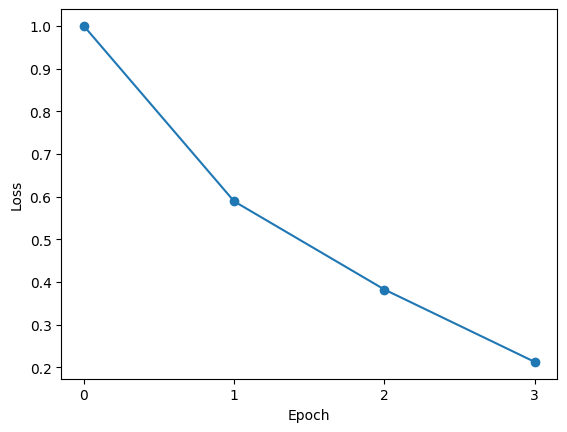

In [ ]:
plt.plot([1, 0.5891, 0.3825, 0.2129], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3])
plt.show()


In [ ]:
evaluation_history = trainer.evaluate()
evaluation_history

{'eval_loss': 1.1559244394302368,
 'eval_accuracy': 0.7578125,
 'eval_runtime': 5.8175,
 'eval_samples_per_second': 66.008,
 'eval_steps_per_second': 8.251,
 'epoch': 3.0}

In [ ]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [ ]:
print(classification_report(prediction, actual_label, target_names=["Netral", "Positif", "Negatif"]))

              precision    recall  f1-score   support

      Netral       0.83      0.78      0.80        67
     Positif       0.42      0.53      0.47        15
     Negatif       0.64      0.64      0.64        14

    accuracy                           0.72        96
   macro avg       0.63      0.65      0.64        96
weighted avg       0.74      0.72      0.73        96



In [ ]:
print(classification_report(prediction, actual_label, target_names=["Netral", "Positif", "Negatif"]))

              precision    recall  f1-score   support

      Netral       0.87      0.76      0.81        72
     Positif       0.42      0.53      0.47        15
     Negatif       0.50      0.78      0.61         9

    accuracy                           0.73        96
   macro avg       0.60      0.69      0.63        96
weighted avg       0.77      0.73      0.74        96



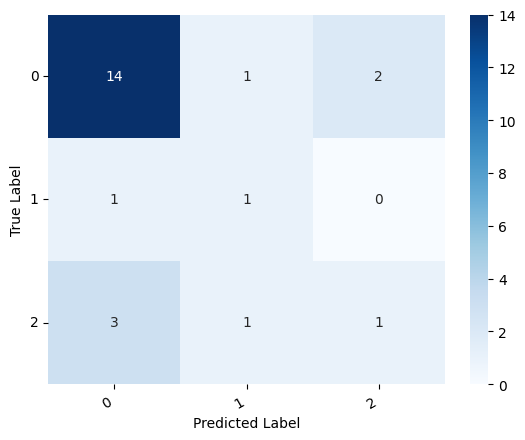

In [ ]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

### **Save And Load Model**

In [ ]:
model.save_pretrained("model")

Configuration saved in model\config.json
Model weights saved in model\pytorch_model.bin


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("model")

In [ ]:
trainer = Trainer(model=model)

In [ ]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    label = trainer.predict([tokenized]).predictions.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Negatif [{label}]')
    elif label == 1:
        print(f'Predicted: Netral [{label}]')
    else:
        print(f'Predicted: Positif [{label}]')


In [ ]:
predict("""
    universitas telkom mahal banget bayar bpp full
    padahal kuliah online gak dikembalikan duitnya
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8
2it [02:29, 74.55s/it]               

Predicted: Negatif [0]


In [ ]:
predict("saya senang sekali kuliah di universitas telkom")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8
3it [02:37, 47.00s/it]

Predicted: Positif [2]


In [ ]:
predict("kuliah online di tel-u enak-enak aja kok")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8
4it [02:41, 30.80s/it]

Predicted: Netral [1]


In [ ]:
print(classification_report(prediction, actual_label, target_names=["Netral", "Positif", "Negatif"]))

              precision    recall  f1-score   support

      Netral       0.83      0.78      0.80        67
     Positif       0.42      0.42      0.42        19
     Negatif       0.57      0.80      0.67        10

    accuracy                           0.71        96
   macro avg       0.61      0.67      0.63        96
weighted avg       0.72      0.71      0.71        96



In [ ]:
print(classification_report(prediction, actual_label, target_names=["Netral", "Positif", "Negatif"]))

              precision    recall  f1-score   support

      Netral       0.84      0.78      0.81        68
     Positif       0.37      0.54      0.44        13
     Negatif       0.71      0.67      0.69        15

    accuracy                           0.73        96
   macro avg       0.64      0.66      0.65        96
weighted avg       0.76      0.73      0.74        96

